# Track-cluster-matching 

So here are the results from running the the `analysis.sub` file in `src` but using `create_jet_based_tree.py` with the 3rd argument `True` that will then artificially do track-cluster matching for neutral pfos which have an charged MC. If there is any track associated to the MC I will "add" it to the pfo aka modifying the `type` and adding track information (like SIP, cov matrix..). 

In [1]:
save_status = False

In [2]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['tree;1']
    data = tree.arrays(library="np", entry_start=0, entry_stop=25000) #entry_stop=1000000)
    return data

In [9]:
path= "/eos/experiment/fcc/ee/datasets/CLD_fullsim_art-tc-match/hadded"
dic = {
    "uu": np.array([]),
    "dd": np.array([]),
    "ss": np.array([]),
    "cc": np.array([]),
    "bb": np.array([]),
    "gg": np.array([]),
    "tautau": np.array([])
}

for process in dic.keys():
    data = load_data(f"{path}/H{process}.root")
    dic[process] = data

In [10]:
dic["bb"].keys()

dict_keys(['event_number', 'n_hit', 'n_part', 'jet_p', 'jet_e', 'jet_mass', 'jet_nconst', 'jet_npfcand', 'jet_theta', 'jet_phi', 'recojet_isG', 'recojet_isU', 'recojet_isD', 'recojet_isS', 'recojet_isC', 'recojet_isB', 'recojet_isTAU', 'pfcand_e', 'pfcand_p', 'pfcand_theta', 'pfcand_phi', 'pfcand_type', 'pfcand_charge', 'pfcand_isEl', 'pfcand_isMu', 'pfcand_isGamma', 'pfcand_isNeutralHad', 'pfcand_isChargedHad', 'jet_nmu', 'jet_nel', 'jet_ngamma', 'jet_nnhad', 'jet_nchad', 'pfcand_erel_log', 'pfcand_phirel', 'pfcand_thetarel', 'pfcand_dptdpt', 'pfcand_detadeta', 'pfcand_dphidphi', 'pfcand_dxydxy', 'pfcand_dzdz', 'pfcand_dxydz', 'pfcand_dphidxy', 'pfcand_dlambdadz', 'pfcand_dxyc', 'pfcand_dxyctgtheta', 'pfcand_phic', 'pfcand_phidz', 'pfcand_phictgtheta', 'pfcand_cdz', 'pfcand_cctgtheta', 'pfcand_dxy', 'pfcand_dz', 'pfcand_btagSip2dVal', 'pfcand_btagSip2dSig', 'pfcand_btagSip3dVal', 'pfcand_btagSip3dSig', 'pfcand_btagJetDistVal', 'pfcand_btagJetDistSig', 'pfcand_mtof', 'pfcand_dndx', 'pf

Now lets consider the plots - what do I need to do? 


so I have the key `pfcand_track_cluster_matching` which is either 
- 0: no correction (neutral)
- 1: correction (neutral)
- 2: couldn't apply correction (neutral)
- 3: charged (not applicable)


So, lets look at all particles that are not 3. And then plots 0,1,2, as a fraction of all over momentum and theta for different H channels. 

In [11]:
def return_i_neutrals(Htype, i, obs):
    """find partilces that have either 0,1,2 for pfcand_track_cluster_matching. Obs could be theta or momentum"""
    index = np.where(np.concatenate(dic[Htype]["pfcand_track_cluster_matching"]) == i)
    return np.concatenate(dic[Htype][obs])[index]

In [12]:
# Normalize function
def normalize_hist(data, ref_counts, bins, range):
    clipped_data = np.clip(data, range[0], range[1]) # for overlfow bins
    counts, _ = np.histogram(clipped_data, bins=bins, range=range, density=False)
    # Avoid division by zero by using np.where
    normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)
    return normalized_counts

In [15]:
def plot_matching(Htype, save=False):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"H{Htype} track-cluster matching (neutral pfos)")
    num_bins = 60
    obsv = ["pfcand_p", "pfcand_theta"]
    ranges = [(1e-1, 80), (0, np.pi)]
    labels = ["true neutrals", "corrected to charged", "charged but no track"]
    for i, obs in enumerate(obsv):
        # Logarithmic binning for "momentum"
        if obs == "pfcand_p":
            bins = np.logspace(np.log10(ranges[i][0]), np.log10(ranges[i][1]), num_bins)
            axs[i].set_xscale("log")
        else:
            bins = np.linspace(ranges[i][0], ranges[i][1], num_bins)

        i_all_neutrals = np.where(np.concatenate(dic[Htype]["pfcand_track_cluster_matching"]) != 3)
        ref_counts, bin_edges = np.histogram(np.clip(np.concatenate(dic[Htype][obs])[i_all_neutrals], ranges[i][0], ranges[i][1]), range=ranges[i], bins=bins, density=False)
        for j in range(3):
            index = np.where(np.concatenate(dic[Htype]["pfcand_track_cluster_matching"]) == j)
            obs_data = np.concatenate(dic[Htype][obs])[index]
            normalized_obs_data = normalize_hist(obs_data, ref_counts, bins, range=ranges[i])
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting
            frac = np.round((np.sum(index[0])/np.sum(i_all_neutrals[0]))*100, 1)
            axs[i].plot(bin_centers, normalized_obs_data, drawstyle='steps-mid', linewidth=2.0, label=f"{labels[j]} ({frac}) %" )
            axs[i].set_xlabel(obs)
            axs[i].grid()
            axs[i].legend()
    
    if save:
        plt.savefig(f"./hist-matching/matching_{Htype}_ptrack.pdf")
    plt.show()

/tmp/ipykernel_67124/1718562499.py:6: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


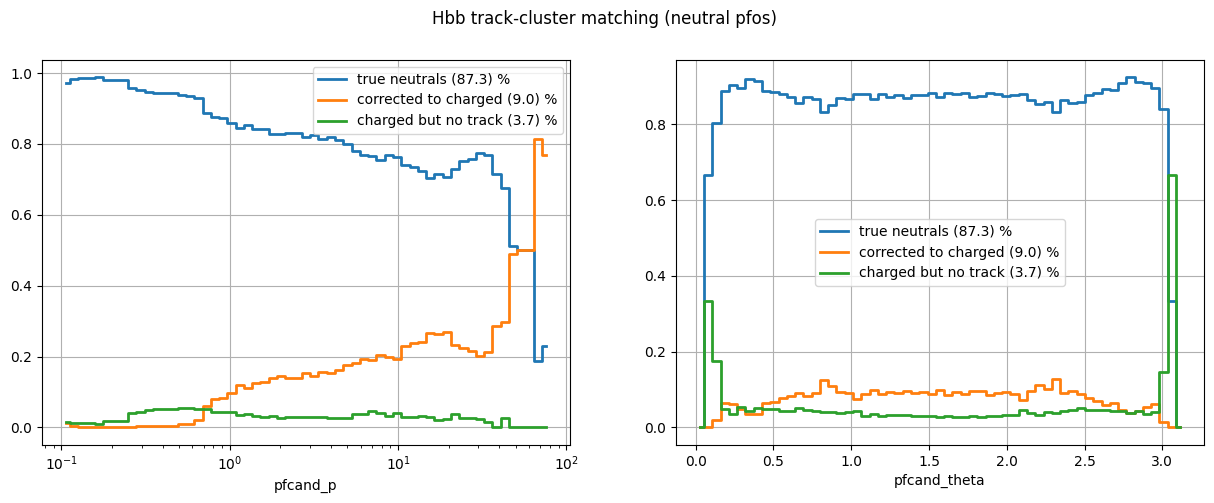

In [16]:
plot_matching("bb", save=save_status)